# C964 Project Walkthrough Notebook
### This is just a notebook available for a walkthrough of my data prep, model training, and testing
### the results of this notebook were then refined and transposed into the utilities.py file and the final app.ipynb notebook

In [1]:
# install all dependencies for the project
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu117
!pip install transformers nltk matplotlib
!pip install pandas numpy scikit-learn
!pip install seaborn wordcloud

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117


In [2]:
# import everything you just installed!
import pandas
import numpy
import matplotlib.pyplot as plotter
import seaborn
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem.porter import PorterStemmer
from collections import Counter
from wordcloud import WordCloud
import torch
from torch.utils.data import Dataset, DataLoader
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random

In [4]:
# download necessary parts from nltk libraries
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chels\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\chels\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
# read training data into pandas dataframe from .csv
data = pandas.read_csv('train.csv')

In [6]:
# initialize porter stemmer and lemmatizer
stemmer = PorterStemmer()
word_net_lemmatizer = nltk.stem.WordNetLemmatizer()

In [7]:
# make dictionary for stop words for easier cleaning of data
stop_words = stopwords.words('english')
stopwords_dictionary = Counter(stop_words)

In [8]:
# drop unneeded ID column from data
data = data.drop(['id'], axis=1)

In [9]:
# function for cleaning up text with some regex to remove URLs, punctuations,special characters, etc
def text_cleaner(input):
    input = str(input).replace(r'http[\w:/\.]+', ' ')
    input = str(input).replace(r'[^\.\w\s]', ' ')
    input = str(input).replace(r'[^a-zA-Z]', ' ')
    input = str(input).replace(r'\s\s+', ' ')
    input = input.lower().strip()

    return input

In [10]:
# function for preprocessing the text for training purposes, splitting, removing stop words, joining back up
def preprocess(input):
    input = text_cleaner(input)
    wordlist = re.sub(r'[^\w\s]', '', input).split()
    input = ' '.join([word_net_lemmatizer.lemmatize(input) for input in wordlist if input not in stopwords_dictionary])
    
    return input

In [11]:
# make sure there's no null values in the title or text of any article data
data.loc[data['title'].isnull(), 'title'] = 'None'
data.loc[data['text'].isnull(), 'text'] = 'None'

In [12]:
# preprocess the data with the previous functions now
data['text'] = data.text.apply(preprocess)
data['title'] = data.title.apply(preprocess)

In [13]:
# a snapshot of our squeaky clean data
data.head()

,title,author,text,label
0,house dem aide didnt even see comeys letter ja...,Darrell Lucus,house dem aide didnt even see comeys letter ja...,1
1,flynn hillary clinton big woman campus breitbart,Daniel J. Flynn,ever get feeling life circle roundabout rather...,0
2,truth might get fired,Consortiumnews.com,truth might get fired october 29 2016 tension ...,1
3,15 civilian killed single u airstrike identified,Jessica Purkiss,video 15 civilian killed single u airstrike id...,1
4,iranian woman jailed fictional unpublished sto...,Howard Portnoy,print iranian woman sentenced six year prison ...,1


In [14]:
# set up variables to hold our true and fake news separately for visualization purposes
true_news = ' '.join(data[data['label']==0]['text'])
fake_news = ' '.join(data[data['label']==1]['text'])

In [15]:
# first we'll initialize some settings for our wordclouds
wordcloud = WordCloud(background_color='pink', width=350, height=350)

# a function to generate some word cloud visuals with the plotter functionality
def wordcloud_generator(input):
    text_on_cloud = wordcloud.generate(input)
    
    plotter.figure(figsize=(8, 8))
    plotter.imshow(text_on_cloud)
    plotter.axis('off')
    plotter.show()

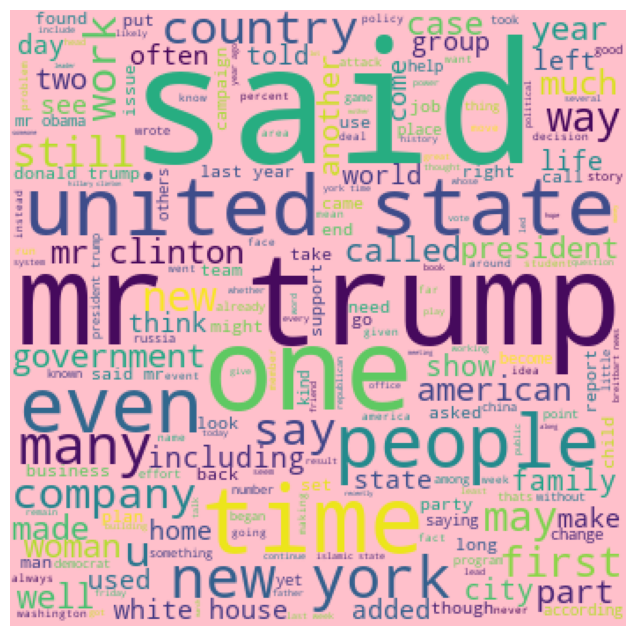

In [16]:
# a wordcloud of the most frequently occurring words in the true news training set
wordcloud_generator(true_news)

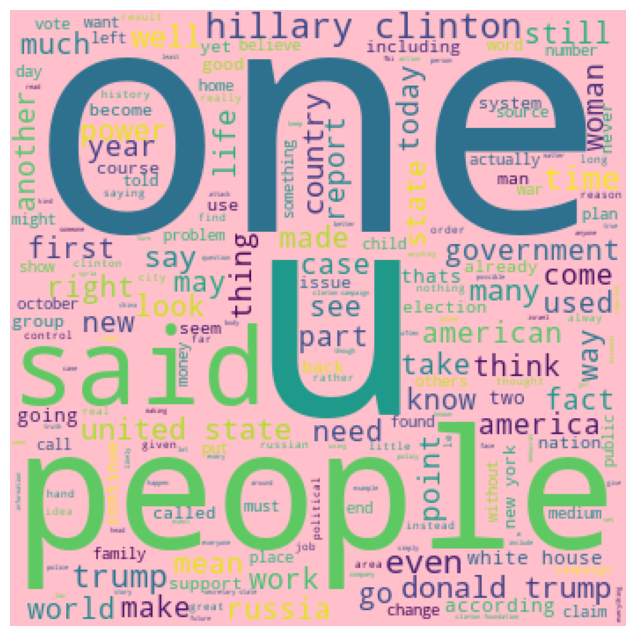

In [17]:
# a wordcloud of the most frequently occurring words in the fake news training set
wordcloud_generator(fake_news)

In [18]:
# a function to generate some bar graphs showing most commonly occurring word combinations in the training data
def plot_most_occurring_combinations(corpus, title, ylabel, xlabel='# of Times Used', n=2):
    top_combinations = (pandas.Series(nltk.ngrams(corpus.split(), n)).value_counts())[:15]
    top_combinations.sort_values().plot.barh(color='pink', width=.8, figsize=(10, 10))
    plotter.title(title)
    plotter.ylabel(ylabel)
    plotter.xlabel(xlabel)
    plotter.show()

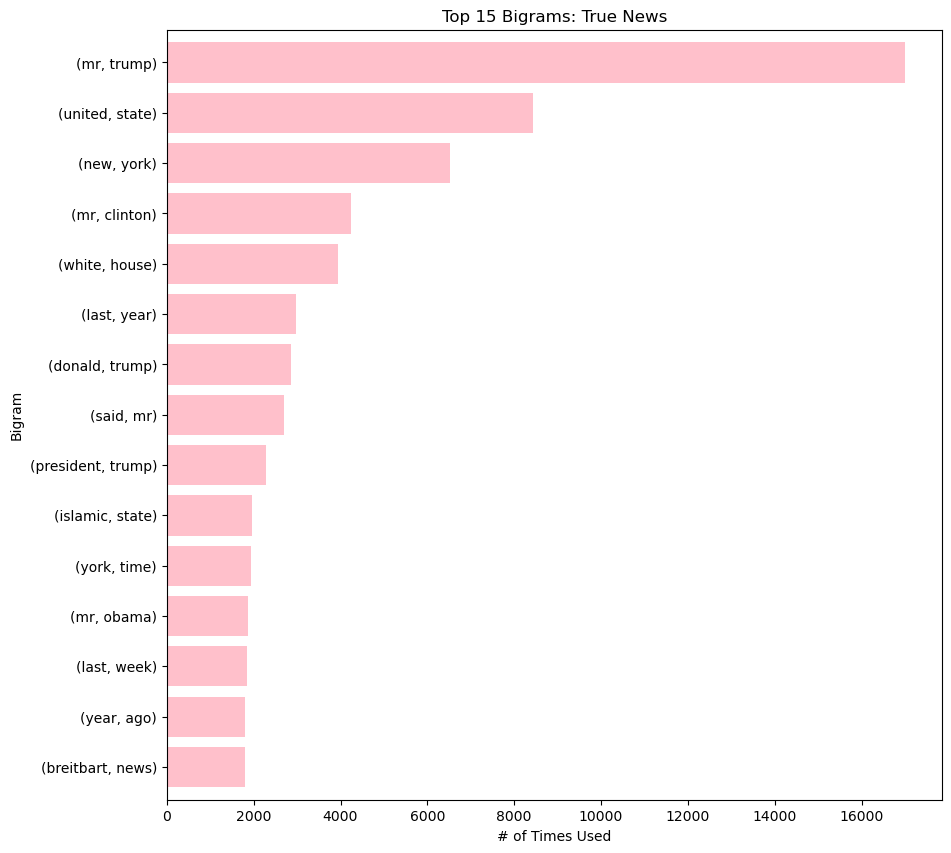

In [19]:
# a bar graph showing top 15 bigrams (2 word combinations) for true news
plot_most_occurring_combinations(true_news, 'Top 15 Bigrams: True News', 'Bigram')

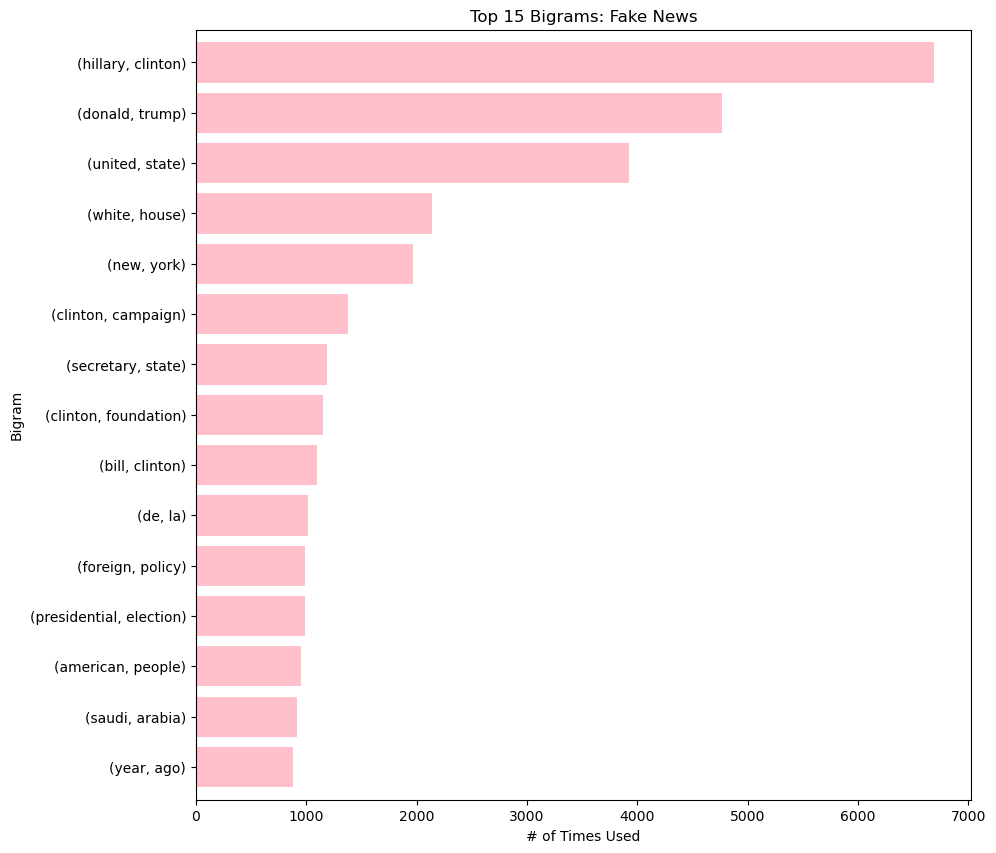

In [20]:
# a bar graph showing top 15 bigrams for fake news
plot_most_occurring_combinations(fake_news, 'Top 15 Bigrams: Fake News', 'Bigram')

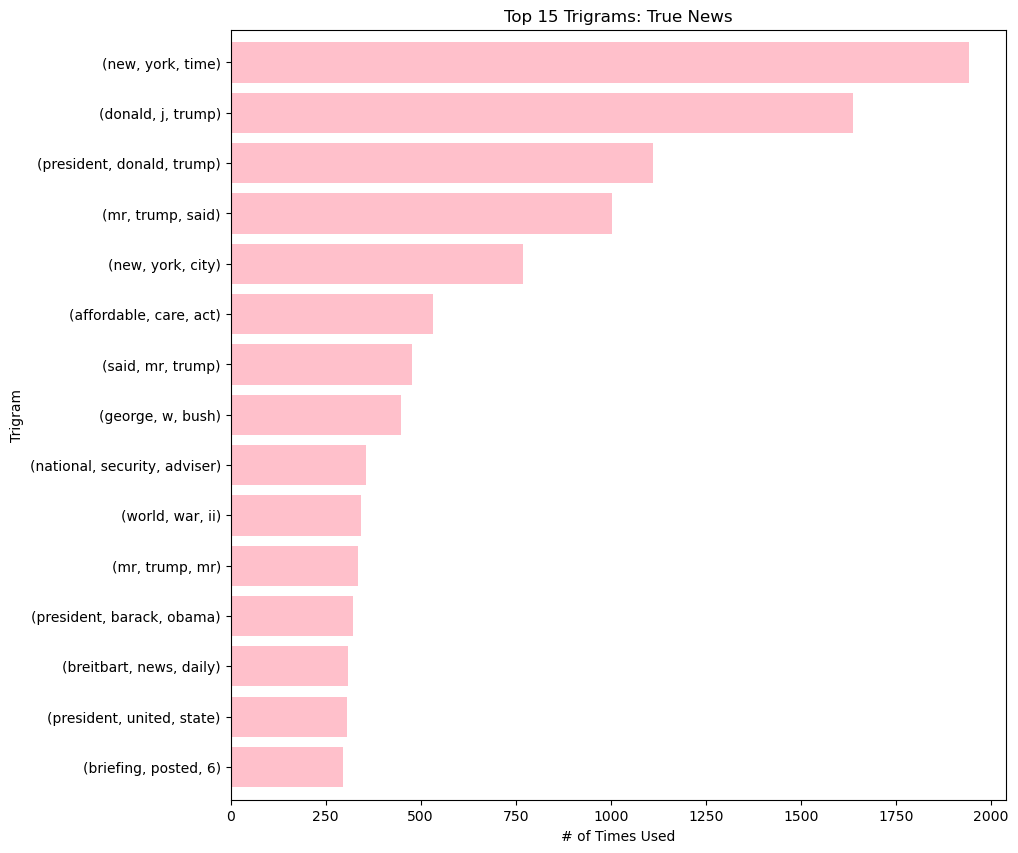

In [21]:
# a bar graph showing top 15 trigrams (3 word combinations) for true news
plot_most_occurring_combinations(true_news, 'Top 15 Trigrams: True News', 'Trigram', n=3)

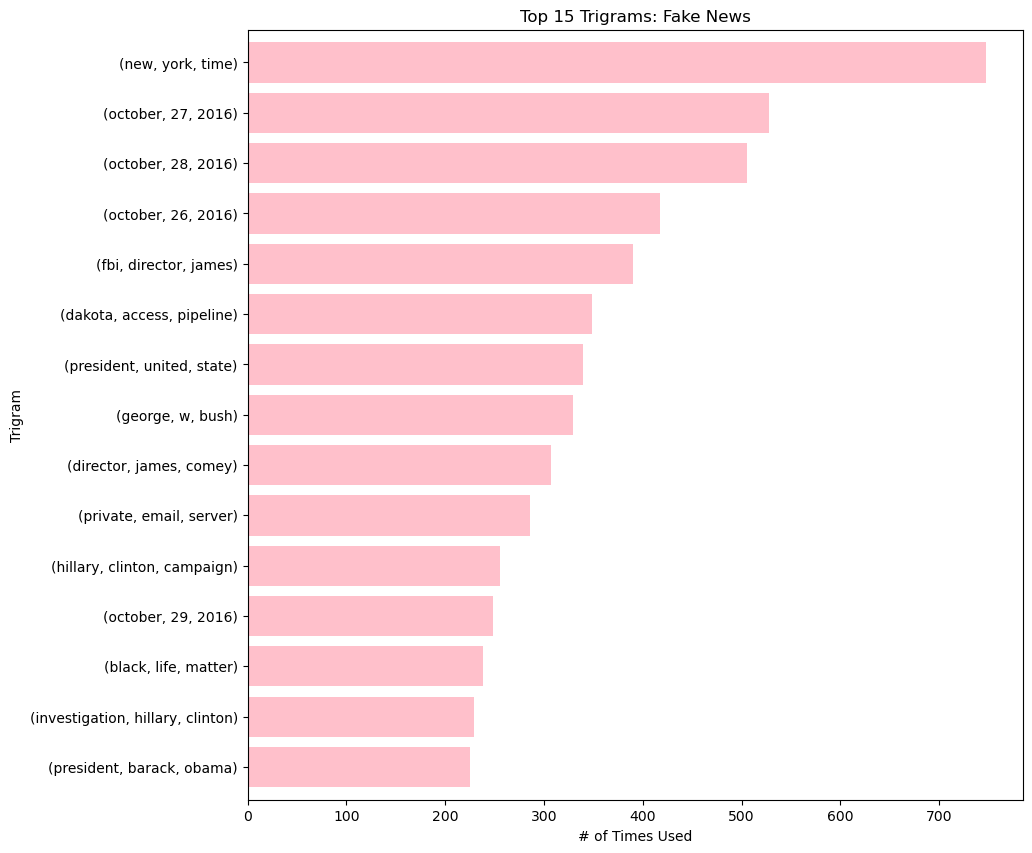

In [22]:
# a bar graph showing top 15 trigrams (3 word combinations) for fake news
plot_most_occurring_combinations(fake_news, 'Top 15 Trigrams: Fake News', 'Trigram', n=3)

In [23]:
# function to set seed across all options for reproducability of results
def seed(int):
    random.seed(int)
    numpy.random.seed(int)
    
    if is_tf_available():
        import tensorflow
        tensorflow.set_seed(int)
    if is_torch_available():
        torch.manual_seed(int)
        torch.cuda.manual_seed_all(int)

In [24]:
seed(1)

In [23]:
# now we're going to set up our BERT based model!  First, we set up the tokenizer based on the open source 'bert-base-uncased' model
model_title = 'bert-base-uncased'
max_length = 512

tokenizer = BertTokenizerFast.from_pretrained(model_title, do_lower_case=True)

In [16]:
# make sure not a number values are converted
data = data[data['text'].notna()]
data = data[data['title'].notna()]

In [27]:
# a function that preps our data into train/test split stacks for the training cycle
def prep_to_train(input, test_size=0.2):
    texts = []
    labels = []
    
    for i in range(len(data)):
        text = data['text'].iloc[i]
        label = data['label'].iloc[i]
        text = data['title'].iloc[i] + ' - ' + text
        if text and label in [0, 1]:
            texts.append(text)
            labels.append(label)

    return train_test_split(texts, labels, test_size=test_size)

In [28]:
# get our training and validation texts and label sets set up
# print should return same values to make sure all texts have accounted for labels
training_texts, valid_texts, training_labels, valid_labels = prep_to_train(data)
print(len(training_texts), len(training_labels))
print(len(valid_texts), len(valid_labels))

16640 16640
4160 4160


In [29]:
# set up encodings for training
training_encodings = tokenizer(training_texts, truncation=True, padding=True, max_length=max_length)
valid_encodings = tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length)

In [30]:
# now we make a custom torch utility dataset that utilizes the tensor grid to interact with data
class CustomGroupsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __getitem__(self, index):
        item = {x: torch.tensor(y[index]) for x, y in self.encodings.items()}
        item['labels'] = torch.tensor([self.labels[index]])
        return item
    
    def __len__(self):
        return len(self.labels)

In [36]:
# and set up our datasets for training and validation as these custom datasets
training_torch_dataset = CustomGroupsDataset(training_encodings, training_labels)
valid_torch_dataset = CustomGroupsDataset(valid_encodings, valid_labels)

# and specify dataloaders so we can speed up training efforts
training_dataloader = DataLoader(
    dataset=training_torch_dataset,
    num_workers=12,
    pin_memory=True
)

valid_dataloader = DataLoader(
    dataset=valid_torch_dataset,
    num_workers=12,
    pin_memory=True
)

In [37]:
# initialize our model
model = BertForSequenceClassification.from_pretrained(model_title, num_labels=2)

loading configuration file config.json from cache at C:\Users\chels/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb421b\config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\chels/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb421b\pytorch_model.bin
Some weights 

In [38]:
# and a function to define how to determine metrics for the classifying model
def determine_metrics(prediction):
    labels = prediction.label_ids
    predictions = prediction.predictions.argmax(-1)
    accuracy = accuracy_score(labels, predictions)
    return {
        'accuracy': accuracy
    }

In [39]:
# initialize the training arguments and trainer
training_arguments = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=15,
    per_gpu_eval_batch_size=30,
    warmup_steps=100,
    logging_dir='./logs',
    load_best_model_at_end=True,
    logging_steps=400,
    save_steps=400,
    evaluation_strategy='steps',
)

trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=training_torch_dataset,
    eval_dataset=valid_torch_dataset,
    compute_metrics=determine_metrics
)

using `logging_steps` to initialize `eval_steps` to 400
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [40]:
# and now we train!
trainer.train()

***** Running training *****
  Num examples = 16640
  Num Epochs = 1
  Instantaneous batch size per device = 15
  Total train batch size (w. parallel, distributed & accumulation) = 15
  Gradient Accumulation steps = 1
  Total optimization steps = 1110
  Number of trainable parameters = 109483778


Step,Training Loss,Validation Loss


KeyboardInterrupt: 

In [1]:
trainer.evaluate()

NameError: name 'trainer' is not defined

In [20]:
# saving the model
final_model_name = 'bert-base-uncased-fake-news'
model.save_pretrained(final_model_name)
tokenizer.save_pretrained(final_model_name)

NameError: name 'model' is not defined

In [21]:
updated_model = BertForSequenceClassification.from_pretrained("./results/checkpoint-400/")

In [24]:
updated_model.save_pretrained('the-final-bert-base-model')
tokenizer.save_pretrained('the-final-bert-base-model')

('the-final-bert-base-model\\tokenizer_config.json',
 'the-final-bert-base-model\\special_tokens_map.json',
 'the-final-bert-base-model\\vocab.txt',
 'the-final-bert-base-model\\added_tokens.json',
 'the-final-bert-base-model\\tokenizer.json')

In [32]:
def predict(input, convert_to_label=False):
    inputs = tokenizer(input, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
    outputs = updated_model(**inputs)
    # get output probabilities by doing softmax
    probs = outputs[0].softmax(1)
    # executing argmax function to get the candidate label
    d = {
        0: "true news",
        1: "fake news"
    }
    if convert_to_label:
      return d[int(probs.argmax())]
    else:
      return int(probs.argmax())

In [33]:
test_news = """
Tim Tebow Will Attempt Another Comeback, This Time in Baseball - The New York Times",Daniel Victor,"If at first you don’t succeed, try a different sport. Tim Tebow, who was a Heisman   quarterback at the University of Florida but was unable to hold an N. F. L. job, is pursuing a career in Major League Baseball. <SNIPPED>
"""

In [34]:
test_news_2 = """
Sunday on MSNBCâ€™s â€œAM Joy,â€ actor and director Rob Reiner accused President Donald Trump of being â€œmentally unstable. â€  Reiner said, â€œItâ€™s scary, itâ€™s scary, because if you look at the capacity that cyber warfare has, and if you know about Stuxnet, which some people do and donâ€™t know about that, they were able to weaponize, you know, a cyber warfare and actually go in and blow up centrifuges in Iran.  Thatâ€™s what scares me. We donâ€™t have, anybody at the helm of our country right now. He is  â€”   you know, I hate to say it, we donâ€™t want to use the word mentally ill, but he is mentally unstable, this man, and so who is going to take charge here when the next attack. â€ â€œIf the first attack, which was going into our elections, which we know happened, if it had been that a bomb blew up in New York, everybody would be going crazy, he continued. â€œThatâ€™s what happened. He blew up something. And now he could blow more stuff up. So we have to be  â€”   you know, weâ€™ve got to make sure that our country is stable. And right now itâ€™s not stable. â€ Follow Pam Key on Twitter @pamkeyNEN
"""

In [35]:
predict(test_news, convert_to_label=True)

'true news'

In [36]:
predict(test_news_2, convert_to_label=True)

'fake news'